## NBA player clustering 

Use KMeans to cluster NBA players based on how similar they are in playing style (e.g. aggressivity, defensiveness). 

* Use the following URL to grab a subset of NBA players to cluster: https://stats.nba.com/stats/commonallplayers?LeagueId=00&Season=2016-17&IsOnlyCurrentSeason=0

* Use the following URL to grab summary statistics for NBA players: https://stats.nba.com/stats/playercareerstats?PerMode=PerGame&PlayerID=X where “X” is the relevant player id grabbed from the first URL.

 * Grab and massage data from the above URLs to feed into K-Means
 * Automatically choose the right parameters for K-means when producing the final clusters
 * Print the final player clusters in the following format {0 [{player_id: 24132, first_name: “Kobe”, last_name: “Bryant”}, {...}, {...}, ...], 1: [...], 2: [...], ...}
 
 ***
 
 ## Solution


In [2]:
import requests #NBA stats API can be very slow; some recommend using aiohttp instead  of requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn import manifold
import seaborn as sns

In [18]:
sample_fraction = 0.3 # fraction of players to run clustering on 
min_games_played = 50 # only include players with games_played > min_games_played
n_init_kmeans = 20 # number of random initializations for KMeans clustering
max_cluster_size = 10 # maximum number of KMeans clusters

**Grab a sample of NBA players:**

In [19]:
# adjust headers if having trouble with the connection
headers = {'user-agent': "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/74.0.3729.169 Chrome/74.0.3729.169 Safari/537.36"}
url = "https://stats.nba.com/stats/commonallplayers?LeagueId=00&Season=2016-17&IsOnlyCurrentSeason=0"
response = requests.request("GET", url, headers=headers)
json_data = response.json() # parse JSON
col = json_data['resultSets'][0]['headers'] #column names for players dataframe
players = json_data['resultSets'][0]['rowSet'] #players data
players_df = pd.DataFrame(players, columns=col) #create dataframe 

#sample only from players that started after 2000
players_df['TO_YEAR']= players_df['TO_YEAR'].apply(lambda x:int(x)) #convert TO_YEAR column to numerical
players_df_after_2000 = players_df[players_df['TO_YEAR']>2000] #select only players with TO_YEAR > 2000
players_df_subset = players_df_after_2000.sample(frac=sample_fraction) #sample a fraction of these players
players_df_subset = players_df_subset.loc[:, 'PERSON_ID':'DISPLAY_LAST_COMMA_FIRST'] # only need PLAYER_ID and name information

#clean up name formatting for printing purposes
players_df_subset['FIRST_NAME'] = players_df_subset['DISPLAY_LAST_COMMA_FIRST'].apply(lambda x : x.split(', ', 1)[0] if (len(x.split(', ', 1))==2) else x.split(' ', 1)[0])
players_df_subset['LAST_NAME'] = players_df_subset['DISPLAY_LAST_COMMA_FIRST'].apply(lambda x : x.split(', ', 1)[-1] if (len(x.split(', ', 1))==2) else x.split(' ', 1)[-1])
players_df_subset = players_df_subset.drop('DISPLAY_LAST_COMMA_FIRST', axis=1)

**Grab summary statistics for each player in our sample:**

In [20]:
urlbase = "https://stats.nba.com/stats/playercareerstats?PerMode=PerGame&PlayerID="
stats_list = []
for ix,id in enumerate(players_df_subset['PERSON_ID']):
    url = urlbase + str(id)
    try:
        response = requests.request("GET", url, headers=headers, timeout=10)
    except (requests.exceptions.ConnectionError, requests.exceptions.ReadTimeout): 
        print("Connection/Timeout Error")
        time.sleep(10)
    json_data = response.json() # parse JSON
    col = json_data['resultSets'][1]['headers'] #column names for stats dataframe
    if json_data['resultSets'][1]['rowSet'] and json_data['resultSets'][1]['rowSet'][0][3]  > min_games_played: # only include player if they played more than min_games_played 
        stats_list.append(pd.DataFrame(json_data['resultSets'][1]['rowSet'], columns = col)) #append dataframe to a list
    time.sleep(0.01) #pause, to avoid raising connection errors
    if (ix%100 == 0):
        time.sleep(5) #periodic long pause, to avoid raising connection errors
stats_df = pd.concat(stats_list, ignore_index=True) #concatenate all the dataframes into one

#innner join the stats and the players df to match name info
players_df_subset = players_df_subset.rename(columns = {'PERSON_ID':'PLAYER_ID'}) #rename to match key names
stats_df = pd.merge(players_df_subset, stats_df, how='right') #merge dataframes to get name info

#select features, normalize stats by average minutes played, and scale the data to [0,1] range 
stats_df['FG2M'] = stats_df['FGM']-stats_df['FG3M']  #add FG2M column 
features = ['FG2M', 'FG3M', 'FTM', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF'] #choose subset of features
stats_df_norm = stats_df[features].div(stats_df.MIN, axis=0) #normalize by average minutes played
stats_df_norm = (stats_df_norm - stats_df_norm.min())/(stats_df_norm.max() - stats_df_norm.min())  #equivalent to MinMaxScaler!

**Run KMeans for different cluster sizes, keeping track of sillhoute scores.**

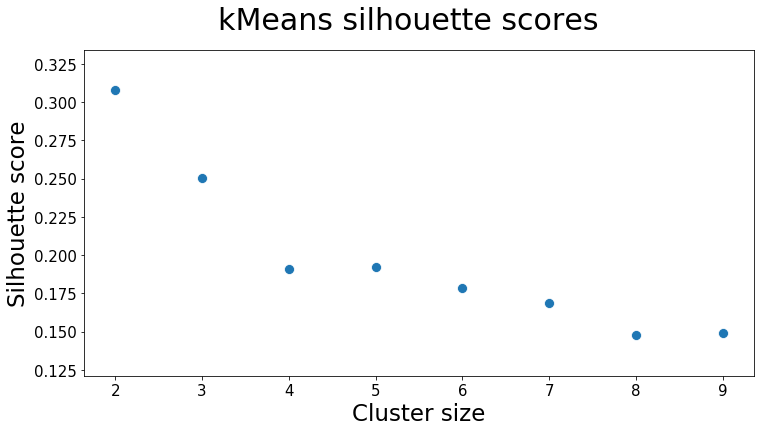

In [21]:
n_cluster_range = range(2, max_cluster_size) #range of cluster sizes to try
kmeans = [KMeans(n_clusters=n_clusters, n_init = n_init_kmeans) for n_clusters in n_cluster_range] #run KMeans for each size
cluster_labels = [km.fit_predict(stats_df_norm) for km in kmeans] #store cluster labels for each cluster size
sil_score = [silhouette_score(stats_df_norm, cl) for cl in cluster_labels] #store silhouette scores for each cluster size
elbow_method = [km.inertia_ for km in kmeans] #(in case we wanted to use elbow method)

#optimal cluster size and corresponding cluster labels
k_optimal = n_cluster_range[sil_score.index(max(sil_score))] #choose optimal k based on sillhoute scores 
cluster_labels = cluster_labels[sil_score.index(max(sil_score))] #optimal cluster labelings

#plot silhouette score versus Cluster Size
df = pd.DataFrame( {"Cluster Size": n_cluster_range, "Silhouette Score": sil_score}) #create dataframe for ploting
fig, ax = plt.subplots(figsize= (12, 6))
g = sns.scatterplot(x="Cluster Size", y="Silhouette Score", data = df, s = 100);
fig.suptitle('kMeans silhouette scores', fontsize = 30)
ax.set_xlabel("Cluster size",fontsize=23)
ax.set_ylabel("Silhouette score",fontsize=23)
ax.tick_params(labelsize=15)

**Print desired output.**

In [22]:
#massaging the dataframe for printing in desired format
stats_df.columns = map(str.lower, stats_df.columns) #column names to lowercase
stats_df['cluster'] = cluster_labels #add column containing cluster label
clusters_list = [stats_df[stats_df['cluster'] == k] for k in range(k_optimal)] #create a dataframe for each cluster and put them all in a list

#using .to_json method plus more massaging to get rid of unwanted quotation marks in the output
output = [', ' + str(k) + ': ' + clusters_list[k].loc[:, 'player_id':'last_name'].to_json(orient='records').replace('{"', '{').replace(',"', ', ').replace('":', ': ').replace('},{', '}, {',) for k in range(k_optimal)]
output = ''.join(output).replace(', 0', '0') #join all the strings in the list into the final output string
output = '{' + output + '}' #add outer braces 


print(output) 

{0: [{player_id: 690, first_name: "Reid", last_name: "Don"}, {player_id: 1043, first_name: "McCaskill", last_name: "Amal"}, {player_id: 1900, first_name: "Lewis", last_name: "Quincy"}, {player_id: 1898, first_name: "Bowdler", last_name: "Cal"}, {player_id: 2414, first_name: "Borchardt", last_name: "Curtis"}, {player_id: 202366, first_name: "Jordan", last_name: "Jerome"}, {player_id: 2071, first_name: "Oyedeji", last_name: "Olumide"}, {player_id: 2735, first_name: "Childress", last_name: "Josh"}, {player_id: 201632, first_name: "Haddadi", last_name: "Hamed"}, {player_id: 708, first_name: "Garnett", last_name: "Kevin"}, {player_id: 431, first_name: "Kemp", last_name: "Shawn"}, {player_id: 1627737, first_name: "Chriss", last_name: "Marquese"}, {player_id: 2599, first_name: "Hunter", last_name: "Brandon"}, {player_id: 712, first_name: "Bennett", last_name: "Mario"}, {player_id: 202685, first_name: "Valanciunas", last_name: "Jonas"}, {player_id: 200797, first_name: "Hollins", last_name: "Ry

**Project data onto the first four principal components in order to better visualize the result of KMeans.**

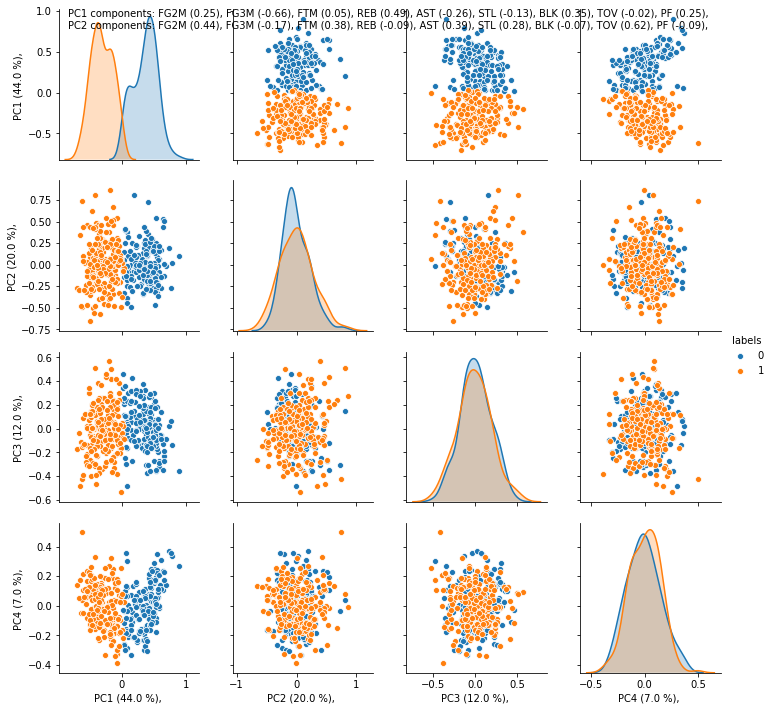

In [23]:
pca = PCA(n_components=4)            
stats_4D_df = pd.DataFrame(pca.fit_transform(stats_df_norm)) #projected data
explained_var = pca.explained_variance_ratio_ #explained variance
columns = ['PC1 (' + str(round(explained_var[0]*100)) + ' %), ' , 'PC2 (' + str(round(explained_var[1]*100)) + ' %), ', 
           'PC3 (' + str(round(explained_var[2]*100)) + ' %), ', 'PC4 (' + str(round(explained_var[3]*100)) + ' %), ']
stats_4D_df.columns = columns #set dataframe column names
stats_4D_df['labels'] = cluster_labels #add columns for labels
g = sns.pairplot(stats_4D_df, hue = "labels", vars = columns) #scatter_matrix
#set figure title to reflect the loadings of the first two principal components 
g.fig.suptitle('PC1 components: ' + ''.join([f + ' (' + str(round(p*100)/100) + '), ' for f,p in zip(features, pca.components_[0])]) + '\n' + 
               'PC2 components: ' + ''.join([f + ' (' + str(round(p*100)/100) + '), ' for f,p in zip(features, pca.components_[1])]) , size = 10)

plt.show()

## Analysis: 

The model reliably finds k = 2 clusters to be the optimal number. This can be explained as there a single dominant clustering dimension, which we may call the defensive - offensive dimension. This conclusion is supported by the PCA performed post-clustering; the scatter matrix of PCs shows that KMeans has succesfully clustered the data along the first PC dimension, but not along the other ones, perhaps indicating that player attributes are quite continuosly distributed, so that clustering simply results in a cut along the direction of maximum variability (PC1). 

This makes sense: given the complexity and demands of modern basketball, players need to be much more versatile and capable of covering the full court rather than having static, rigidly defined roles. While we may imagine other clustering dimensions (besides ofensiveness), such as agressiveness, they may be correlated quite strongly with the main dimension. For example, agressiveness (as quantified by personal fouls or blocks, for example) is very likely correlated to defensiveness; indeed, some of these correlation in the features can be seen if we plot a scatter matrix of the features. Therefor, given the set of features available, there seem to be only two dominant clusters. 

To better understand the clustering dimension, we cann examine the factor loadings returned by PCA: the first principal eigendirection is roughly (FG3M+, AST+, REB-, BLK-, PF-), where a + indicates a large positive loading, while a - indicates a large negative loading (with the rest of the factors ommited). Thus, the main clustering indeed seems to represent or at least correlate with the defensive - offensive axis: on one end we have players who score lots of three pointers and provide lots of assists but have low stats for blocks, rebounds, or personal fouls while on the other end we have the opposite (players who have many blocks, rebounds, and personal fouls, but not many three pointers or assists). 

The t-SNE visualization below is also consistent with the conclusion that the number of clusters is at most 2. 

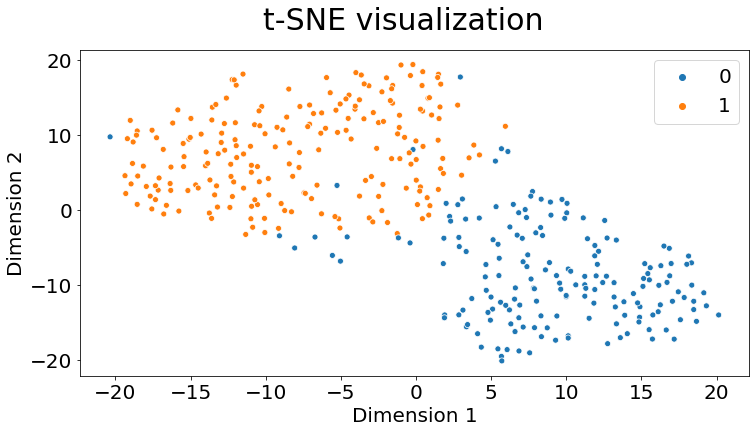

In [24]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
Y = tsne.fit_transform(stats_df_norm)

fig, ax = plt.subplots(figsize= (12, 6))
g = sns.scatterplot(x=Y[:, 0], y=Y[:, 1], hue = cluster_labels)
fig.suptitle('t-SNE visualization', fontsize = 30)
ax.set_xlabel("Dimension 1",fontsize=20)
ax.set_ylabel("Dimension 2",fontsize=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20);